# Tunnel+

***Goal***: To make an improved version of [Location+](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/) that incorporates pitch tunneling. <br>
**Author**: Jensen Holm <br>
**Date**: 2024

In [1]:
import statcast_pitches
import polars as pl
from plotnine import *
import plotly.express as px
import os

LOCAL_DATA_DIR = os.path.join("..", "data")

## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches) 

In [2]:
pitches_lf: pl.LazyFrame = statcast_pitches.load() # default is all pitches

latest_date = pitches_lf.select("game_date").max().collect().item().date()
earliest_date = pitches_lf.select("game_date").min().collect().item().date()
n_pitches = pitches_lf.select(pl.len()).collect().item()

print(f"N Pitches: {n_pitches}")
print(f"Date Range: {earliest_date} - {latest_date}")

N Pitches: 7011927
Date Range: 2015-04-05 - 2024-10-30


In [3]:
run_values_24 = pl.scan_csv(
    os.path.join(LOCAL_DATA_DIR, "run_values.csv"),
).rename({"event": "events"}) # it is called 'events' in pitches_df

## Feature Engineering

adding the following features to `pitches_df`

| Feature Name | Description |
|------|-------------|
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`| 
| **x_0.120** | position in the x dimension of the pitch at decision time (~0.12s) |
| **y_0.120** | position in the y dimension of the pitch at decision time (~0.12s) |
| **z_0.120** | position in the z dimension of the pitch at decision time (~0.12s) |
| **x_0.167** | position in the x dimension of the pitch at commit time (~0.167s) |
| **y_0.167** | position in the y dimension of the pitch at commit time (~0.167s) |
| **z_0.167** | position in the z dimension of the pitch at commit time (~0.167s) |
| **velocity_diff** | difference in velocity between pitches in a two pitch sequence |
| **effective_velocity_diff** | difference in effective velocity between pitches in a two pitch sequence |
| **pfx_x_diff** | difference in horizontal movement between pitches in a two pitch sequence |
| **pfx_z_diff** | difference in vertical movement between pitches in a two pitch sequence |
| **3d_dist_0.167** | 3D euclidean distance between pitches in a two pitch sequence 0.167 seconds after release |
| **3d_dist_0.120** | 3D distance between pitches in a two pitch sequence at 0.120 seconds after release |
| **distance** | 2D euclidean distance between pitch locations when crossing the plate in a two pitch sequence |
| **seq_delta_run_exp** | sum of `delta_run_exp` in a two pitch sequence |
| **plate_x_diff** | difference in plate_x between pitches in a two pitch sequence |
| **plate_z_diff** | difference in plate_z between pitches in a two pitch sequence |

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

Adding `delta_run_exp` first

In [4]:
from utils import description_replace_mapping


def add_pitch_run_value(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Takes in a dataframe of pitches, and adds 2024 run value to each one"""
    pitch_runs_lf = lf.join(
        other=run_values_24,
        on=["events", "balls", "strikes"],
        how="left",
    )

    mapped_des_pitches = pitch_runs_lf.with_columns([
        pl.col("description")
        .replace_strict(description_replace_mapping, default=None)
        .alias("play_des"),
    ])

    pitches_run_value_lf = mapped_des_pitches.join(
        other=run_values_24,
        right_on=["events", "balls", "strikes"],
        left_on=["play_des", "balls", "strikes"],
        how="left",
        suffix="_des",
    ).with_columns([
        pl.when(pl.col("delta_run_exp").is_null())
        .then(pl.col("delta_run_exp_des"))
        .otherwise(pl.col("delta_run_exp"))
        .alias("delta_run_exp"),
    ])
    return pitches_run_value_lf

pitches_run_value_lf = pitches_lf.pipe(add_pitch_run_value)
pitches_run_value_lf.select(
    "pitch_type",
    "description",
    "balls",
    "strikes",
    "delta_run_exp",
).describe()

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""6914851""","""7011927""",7.011927e6,7.011927e6,6.814457e6
"""null_count""","""97076""","""0""",0.0,0.0,197470.0
"""mean""",null,null,0.875591,0.888314,0.000005
"""std""",null,null,0.966838,0.827263,0.242352
"""min""","""AB""","""ball""",0.0,0.0,-1.661
"""25%""",null,null,0.0,0.0,-0.066
"""50%""",null,null,1.0,1.0,-0.017
"""75%""",null,null,1.0,2.0,0.036
"""max""","""SV""","""swinging_strike_blocked""",4.0,3.0,3.702


Mirroring LHP metrics as if they were thrown by RHP

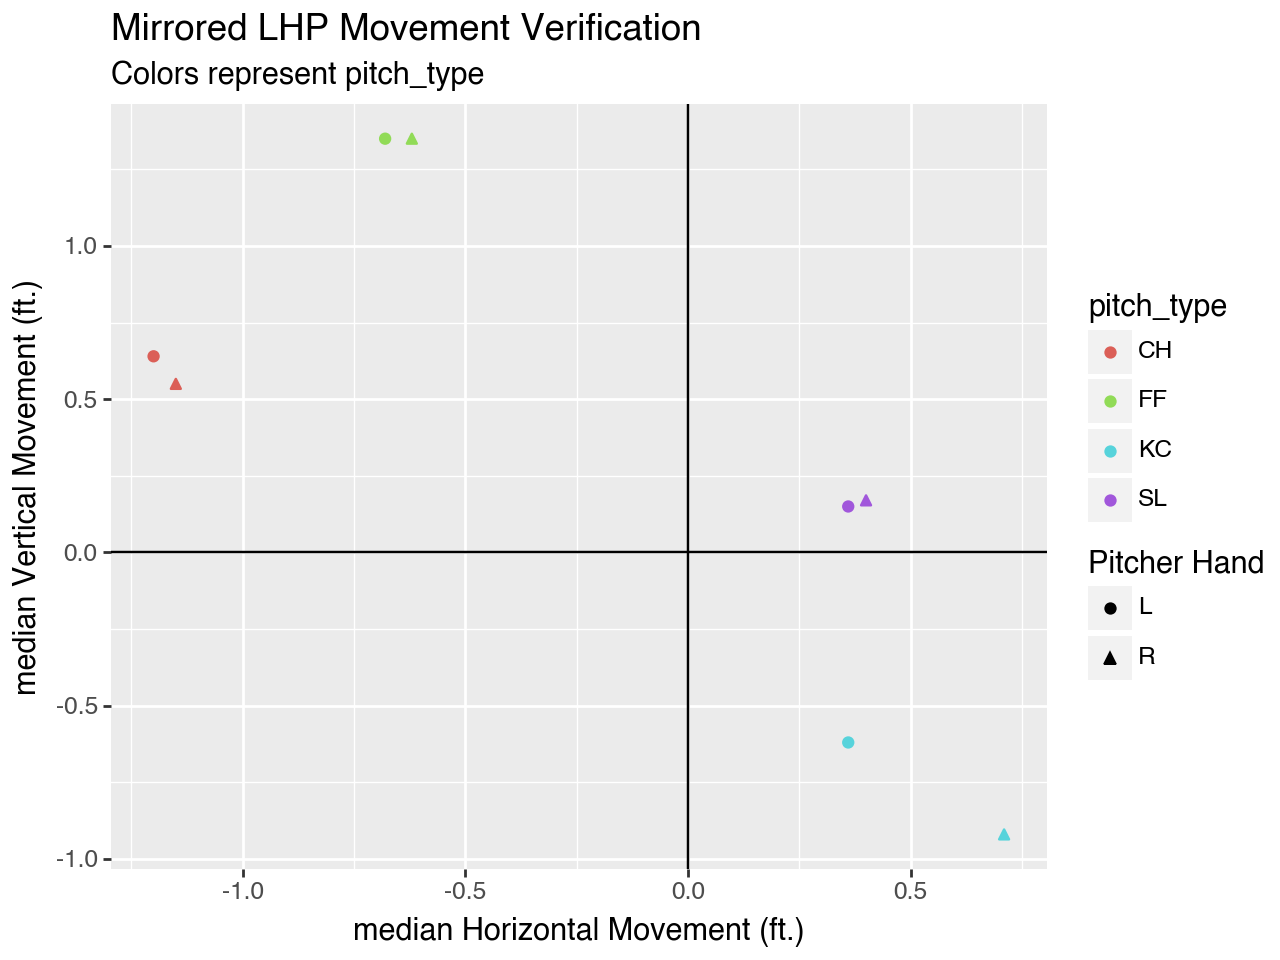

In [5]:
def mirror_lhp_to_rhp(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),
    )

mirrored_pitches_lf = pitches_run_value_lf.pipe(mirror_lhp_to_rhp)

# for verification
movement_plt = (
    ggplot(
        mirrored_pitches_lf
        .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").median().alias("median_pfx_x"),
            pl.col("pfx_z").median().alias("median_pfx_z"),
        ).collect(),
        aes(x="median_pfx_x", y="median_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point()
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + labs(
        title="Mirrored LHP Movement Verification",
        x="median Horizontal Movement (ft.)",
        y="median Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now!

## 3D Pitch Displacement

Now to add ball positions in 3D space at both [decision time]() (0.12s) & [commit time]() (0.167s)

Plugging in our pitch data into the kinematic equation for displacement below, I can solve for where the ball 

$d = v_{i} * t + \frac{1}{2} * a * t^{2}$

**where**:
- $t$ = time (seconds)
- $v_{i}$ = velocity at time $t$
- $a_{i}$ = acceleration at time $t$

**Steps**:

For a given time $t$ ...

1. Estimate how many feet the ball will travel in $t$ seconds (assuming acceleration = az)
2. Estimate the x and y positions of the ball at $t$ seconds (assuming acceleration = ax & ay) 

In [6]:

def calculate_ball_pos_at_t(lf: pl.LazyFrame, *ts) -> pl.LazyFrame:
    """Computes the x, y and z positions of a baseball at all the times in specified in ts"""
    lf = lf.with_columns(
        (50 / pl.col("vz0")).alias("t_50")
    )

    return lf.with_columns([
        ((pl.col(f"release_pos_{dim}") + pl.col(f"v{dim}0") * t) 
         + (1/2 * pl.col(f"a{dim}") * t**2)).alias(f"{dim}_{t:.3f}")
        for dim in ["x", "y", "z"] 
        for t in ts
    ])

# 0.12 is about the 'decision time' and 0.167 is about 'commit time'
ball_pos_lf = mirrored_pitches_lf.pipe(calculate_ball_pos_at_t, 0.12, 0.167)

(ball_pos_lf
    .select("x_0.120", "y_0.120", "z_0.120",
            "x_0.167", "y_0.167", "z_0.167")
    .describe())

statistic,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167
str,f64,f64,f64,f64,f64,f64
"""count""",6.914963e6,6.914963e6,6.914963e6,6.914963e6,6.914963e6,6.914963e6
"""null_count""",96964.0,96964.0,96964.0,96964.0,96964.0,96964.0
"""mean""",-0.52857,38.996143,5.228118,-0.434157,33.098018,4.883754
"""std""",1.312962,1.203188,0.480382,1.126683,1.571288,0.518229
"""min""",-9.999482,11.766347,-3.731836,-15.726781,5.178942,-7.876103
"""25%""",-1.463503,38.117289,4.930833,-1.237707,31.916235,4.547567
"""50%""",-0.9427,38.82612,5.223915,-0.732749,32.848423,4.866291
"""75%""",0.530302,39.784215,5.525332,0.371859,34.142618,5.201602
"""max""",14.906553,52.044098,10.634679,13.706871,50.137116,10.791045


In [7]:
median_ball_loc_df = (ball_pos_lf
                    .filter(pl.col("pitch_type").is_in(["FF", "KC", "CH"]))
                    .drop_nulls(subset=["plate_x", "plate_z", "pitch_type", "release_pos_x", "release_pos_z", "release_pos_y"])
                    .group_by("pitch_type")
                    .agg([
                        pl.col(feature).median().alias(f"median_{feature}")
                        for feature in [
                            "release_pos_x",
                            "release_pos_y",
                            "release_pos_z",
                            "plate_x",
                            "plate_z",
                            "x_0.120",
                            "y_0.120",
                            "z_0.120",
                            "x_0.167",
                            "y_0.167",
                            "z_0.167",
                        ]
                    ])
                    .with_columns(pl.lit(0).alias("plate_y"))
                    .collect())

decision_time_fig = px.scatter_3d(
    median_ball_loc_df,
    x="median_x_0.120",
    y="median_y_0.120",
    z="median_z_0.120",
    color="pitch_type",
    symbol="pitch_type",
)

commit_time_fig = px.scatter_3d(
    median_ball_loc_df,
    x="median_x_0.167",
    y="median_y_0.167",
    z="median_z_0.167",
    color="pitch_type",
    symbol="pitch_type",
)

over_plate_fig = px.scatter_3d(
    median_ball_loc_df,
    x="median_plate_x",
    y="plate_y",
    z="median_plate_z",
    color="pitch_type",
    symbol="pitch_type",
)

release_fig = px.scatter_3d(
    median_ball_loc_df,
    x="median_release_pos_x",
    y="median_release_pos_y",
    z="median_release_pos_z",
    color="pitch_type",
    symbol="pitch_type",
)

for fig in [decision_time_fig, commit_time_fig, release_fig, over_plate_fig]:
    decision_time_fig.add_traces(fig.data)

decision_time_fig.update_layout(
    title="Median Position at commit & decision times in pitch flight",
    scene=dict(
        xaxis_title="X (ft.)",
        yaxis_title="Y (ft.)",
        zaxis_title="Z (ft.)",
    )
).show()

Get pitch sequences and difference features

In [8]:
# features that we are interested in with regards to two pitch sequences
prev_features = [
    "prev_pfx_x",
    "prev_pfx_z",
    "prev_x_0.120",
    "prev_y_0.120",
    "prev_z_0.120",
    "prev_x_0.167",
    "prev_y_0.167",
    "prev_z_0.167",
    "prev_release_pos_x",
    "prev_release_pos_y",
    "prev_release_pos_z",
    "prev_release_speed",
    "prev_effective_speed",
    "prev_release_spin_rate",
    "prev_delta_run_exp",
    "prev_plate_x",
    "prev_plate_z",
]

def two_pitch_sequences(lf: pl.LazyFrame) -> pl.LazyFrame:
    # sort the data such that the pitches are in descending order
    sort_cols = ["pitcher", "game_date", "at_bat_number", "pitch_number"]
    sorted_lf = lf.sort(
        by=sort_cols,
        descending=True,
    )

    return (sorted_lf
        .with_columns([
            pl.col(feature)
            .shift(-1)
            .over(["pitcher", "at_bat_number"])
            .alias(f"prev_{feature}")
            # for feature in sorted_lf.collect_schema().names()
            for feature in [f.replace("prev_", "") for f in prev_features]
        ])
        .select(*sort_cols + prev_features)
        .join(other=lf, on=sort_cols, how="right")
    )

def add_diff_features(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        *[(pl.col(f"{dim}_{t:.3f}") - pl.col(f"prev_{dim}_{t:.3f}"))
          .alias(f"{dim}_diff_{t}")
            for dim in ["x", "y", "z"]
            for t in [0.120, 0.167]],
        (pl.col("release_speed") - pl.col("prev_release_speed")).alias("velocity_diff"),
        (pl.col("effective_speed") - pl.col("prev_effective_speed")).alias("effective_speed_diff"),
        (pl.col("pfx_x") - pl.col("prev_pfx_x")).alias("pfx_diff"),
        (pl.col("pfx_z") - pl.col("prev_pfx_z")).alias("pfx_z_diff"),
        (pl.col("delta_run_exp") + pl.col("prev_delta_run_exp")).alias("seq_delta_run_exp"),
        (pl.col("plate_x") - pl.col("prev_plate_x")).alias("plate_x_diff"),
        (pl.col("plate_z") - pl.col("prev_plate_z")).alias("plate_z_diff"),
        (((pl.col("plate_x") - pl.col("prev_plate_x") ** 2) + 
         (pl.col("plate_z") - pl.col("prev_plate_z") ** 2)) ** 0.5).alias("distance"),
    )


sequence_pitches_lf = (ball_pos_lf
                       .pipe(two_pitch_sequences)
                       .pipe(add_diff_features))

(sequence_pitches_lf
    .select(prev_features)
    .describe())

statistic,prev_pfx_x,prev_pfx_z,prev_x_0.120,prev_y_0.120,prev_z_0.120,prev_x_0.167,prev_y_0.167,prev_z_0.167,prev_release_pos_x,prev_release_pos_y,prev_release_pos_z,prev_release_speed,prev_effective_speed,prev_release_spin_rate,prev_delta_run_exp,prev_plate_x,prev_plate_z
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",6.792066e6,6.792077e6,6.791931e6,6.791931e6,6.791931e6,6.791931e6,6.791931e6,6.791931e6,6.791931e6,6.791931e6,6.791931e6,6.792801e6,6.757507e6,6.633221e6,6.697522e6,6.792146e6,6.792146e6
"""null_count""",232645.0,232634.0,232780.0,232780.0,232780.0,232780.0,232780.0,232780.0,232780.0,232780.0,232780.0,231910.0,267204.0,391490.0,327189.0,232565.0,232565.0
"""mean""",-0.380071,0.661274,-0.528421,38.993871,5.228093,-0.433963,33.094901,4.88352,-0.792222,54.321519,5.874103,88.825833,88.631,2228.093362,-0.000889,0.02854,2.266515
"""std""",0.808343,0.746004,1.312966,1.199226,0.480519,1.126735,1.566307,0.518623,1.895471,0.462979,0.521562,6.032435,6.278894,338.440695,0.233449,0.86744,0.965161
"""min""",-3.0,-2.79,-9.999482,11.766347,-3.731836,-15.726781,5.178942,-7.876103,-10.4,28.58,-3.19,30.4,26.8,4.0,-1.661,-65.16,-45.11
"""25%""",-1.04,0.21,-1.463532,38.115942,4.93059,-1.237731,31.914287,4.546812,-2.14,54.02,5.61,84.6,84.4,2079.0,-0.064,-0.56,1.64
"""50%""",-0.54,0.78,-0.942215,38.82422,5.223941,-0.732043,32.845556,4.866155,-1.5,54.43,5.91,90.0,89.8,2257.0,-0.017,0.03,2.27
"""75%""",0.26,1.26,0.531032,39.782956,5.525756,0.37201,34.140784,5.202118,0.96,54.51,6.2,93.6,93.5,2425.0,0.036,0.61,2.9
"""max""",2.95,2.99,14.906553,52.044098,10.634679,13.706871,50.137116,10.791045,18.0,59.94,10.54,105.7,194.6,3741.0,3.702,11.3,13.58


3D euclidean distances between the baseball at decision and commit points

$3Deuclideandistance = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}$

In [9]:

def add_3D_distances(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # decision & commit time distances
        (((pl.col(f"x_{t:.3f}") - pl.col(f"prev_x_{t:.3f}")) ** 2)
        + ((pl.col(f"y_{t:.3f}") - pl.col(f"prev_y_{t:.3f}")) ** 2)
        + ((pl.col(f"z_{t:.3f}") - pl.col(f"prev_z_{t:.3f}")) ** 2)
        ** 0.5).alias(f"3d_dist_{t:.3f}")
        for t in [0.120, 0.167]
    )

sequence_dist_pitches_lf = sequence_pitches_lf.pipe(add_3D_distances)

(sequence_dist_pitches_lf
    .select("3d_dist_0.120", "3d_dist_0.167")
    .describe())

statistic,3d_dist_0.120,3d_dist_0.167
str,f64,f64
"""count""",6.760001e6,6.760001e6
"""null_count""",264710.0,264710.0
"""mean""",2.326884,3.983626
"""std""",2.976303,5.162673
"""min""",0.0,0.0
"""25%""",0.433054,0.629466
"""50%""",1.089063,1.732825
"""75%""",3.176388,5.559151
"""max""",867.457789,935.674319
